In [17]:
import random

from wbtools.lib.nlp.text_preprocessing import get_documents_from_text
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
from matplotlib import pyplot as plt
import numpy as np
import random
import umap

## Define constants

In [76]:
min_sentence_length = 20
max_num_clusters = 100
max_corpus_size = 100000

## Read positive and negative sentences from file

In [77]:
def read_positive_sentences_from_file(filepath, min_sent_length=20):
    return [sentence for line in open(filepath) for sentence in get_documents_from_text(
        text=line.strip(), split_sentences=True) if len(sentence) > min_sent_length]

sent_expr_pattern = read_positive_sentences_from_file("../extracted_sentences/sentences_exp_pattern.txt",
                                                      min_sentence_length)
sent_subcellloc = read_positive_sentences_from_file("../extracted_sentences/sentences_exp_subcellloc.txt",
                                                    min_sentence_length)
neg_sent_otherxpr = [sent for sent in open("../extracted_sentences/neg_sentences_otherexpr.txt") if len(sent) >
                     min_sentence_length]

## Clean sentences

In [78]:
def clean_sentences(sentences):
    return list(set([sent.strip(' ').strip('.;,/-|') for sent in sentences]))

sent_expr_pattern_clean = clean_sentences(sent_expr_pattern)
sent_subcellloc_clean = clean_sentences(sent_subcellloc)
neg_sent_otherxpr_clean = clean_sentences(neg_sent_otherxpr)

## Sample sentences

In [79]:
def get_random_sentence_subset(sentences, max_num_sentences):
    corpus = sentences
    random.shuffle(corpus)
    return corpus[0:max_num_sentences]

corpus_expr_pattern = get_random_sentence_subset(sent_expr_pattern_clean, max_corpus_size)
corpus_expr_subcellloc = get_random_sentence_subset(sent_subcellloc_clean, max_corpus_size)
corpus_neg_otherexpr = get_random_sentence_subset(neg_sent_otherxpr_clean, max_corpus_size)

## Extract sentence embeddings

In [80]:
embedder = SentenceTransformer('all-MiniLM-L6-v2')
corpus_embeddings_expr_pattern = embedder.encode(corpus_expr_pattern)
corpus_embeddings_subcellloc = embedder.encode(corpus_expr_subcellloc)
corpus_embeddings_neg_otherexpr = embedder.encode(corpus_neg_otherexpr)


In [81]:
umap_reducer = umap.UMAP()
corpus_embeddings_expr_pattern_2d = umap_reducer.fit_transform(corpus_embeddings_expr_pattern)
corpus_embeddings_subcellloc_2d = umap_reducer.fit_transform(corpus_embeddings_subcellloc)
corpus_embeddings_neg_otherexpr_2d = umap_reducer.fit_transform(corpus_embeddings_neg_otherexpr)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [97]:
colors = ['g'] * len(corpus_embeddings_expr_pattern_2d) + ['y'] * len(corpus_embeddings_subcellloc_2d) + ['b'] * len(corpus_embeddings_neg_otherexpr_2d)

In [98]:
all_corpora_2d = np.vstack((corpus_embeddings_expr_pattern_2d, corpus_embeddings_subcellloc_2d, corpus_embeddings_neg_otherexpr_2d))

## UMAP visualization with different colors for each sentence category
expr_pattern = green
subcellloc = yellow
negative = blue

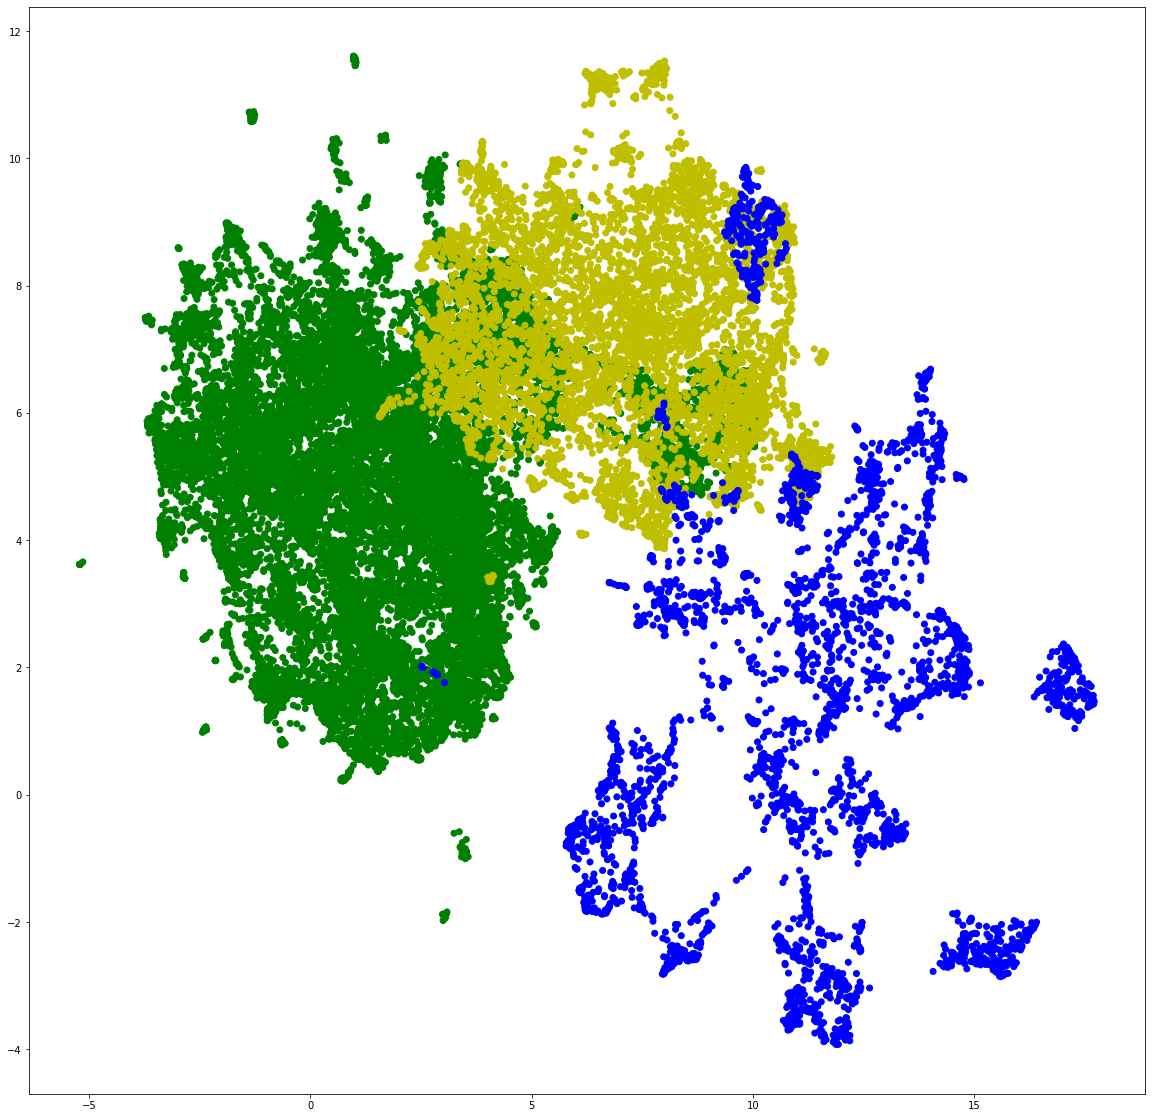

In [100]:
fig_scatter = plt.figure(figsize=(20, 20))
plt.scatter(x=list(all_corpora_2d[:,0]), y=list(all_corpora_2d[:,1]), c=colors)

In [132]:
corpus_expr_pattern_centroid = np.average(corpus_embeddings_expr_pattern, 0)
euclidean_distances_expr_pattern = ([np.linalg.norm(corpus_expr_pattern_centroid - corpus_embeddings_expr_pattern[i,:]) for i in range(len(corpus_embeddings_expr_pattern))])
euclidean_distances_subcellloc_exp_pattern_centroid = ([np.linalg.norm(corpus_expr_pattern_centroid - corpus_embeddings_subcellloc[i,:]) for i in range(len(corpus_embeddings_subcellloc))])
euclidean_distances_neg_sent_exp_pattern_centroid = ([np.linalg.norm(corpus_expr_pattern_centroid - corpus_embeddings_neg_otherexpr[i,:]) for i in range(len(corpus_embeddings_neg_otherexpr))])
print("average distance between exp pattern centroid and exp pattern sentences: " + str(np.average(euclidean_distances_expr_pattern)) + "\naverage distance between exp pattern centroid and subcellloc sentences: " + str(np.average(euclidean_distances_subcellloc_exp_pattern_centroid)) + "\naverage distance between exp pattern centroid and negative sentences: " + str(np.average(euclidean_distances_neg_sent_exp_pattern_centroid)))

average distance between exp pattern centroid and exp pattern sentences: 0.84340894
average distance between exp pattern centroid and subcellloc sentences: 0.8844768
average distance between exp pattern centroid and negative sentences: 0.9741301
